## Install the necessary python libraries

In [357]:
!pip install networkx pandas numpy matplotlib grakel graphrole seaborn

#### Import necessary libraries

In [358]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from grakel.utils import graph_from_networkx
from grakel import GraphKernel
from networkx.algorithms import community
import hashlib
import copy
from collections import Counter
import itertools
import warnings
from pprint import pprint
import seaborn as sns
from graphrole import RecursiveFeatureExtractor, RoleExtractor

## 1. Graph Kernels
### 1.1. Graph Comparison
+ Compare graphs based on their structural properties.
+ Check if two graphs are isomorphic (have the same structure) using nx.is_isomorphic(G1, G2)

In [359]:
import networkx as nx
from itertools import combinations

# A function compares the pair of isomorphic graphs and gets a set of isomorphic  
def find_pair_of_similar_graphs(graphs):
    iso_pairs = {(graphs[g1], graphs[g2]) for g1, g2 in combinations(graphs, 2) if nx.is_isomorphic(g1, g2)}
    return iso_pairs

# Initialize sample graphs
G1 = nx.star_graph(5)
G2 = nx.cycle_graph(5)
G3 = nx.path_graph(6)
G4 = nx.path_graph(4)
G5 = nx.path_graph(4)
G6 = nx.star_graph(5)

graphs = {G1: 'G1', G2: 'G2', G3: 'G3', G4: 'G4', G5: 'G5', G6: 'G6'}


iso_graph = nx.from_edgelist(find_pair_of_similar_graphs(graphs)) 
for similar_graphs in nx.connected_components(iso_graph):
    print(f"Similar graphs: {similar_graphs}")

Similar graphs: {'G1', 'G6'}
Similar graphs: {'G5', 'G4'}


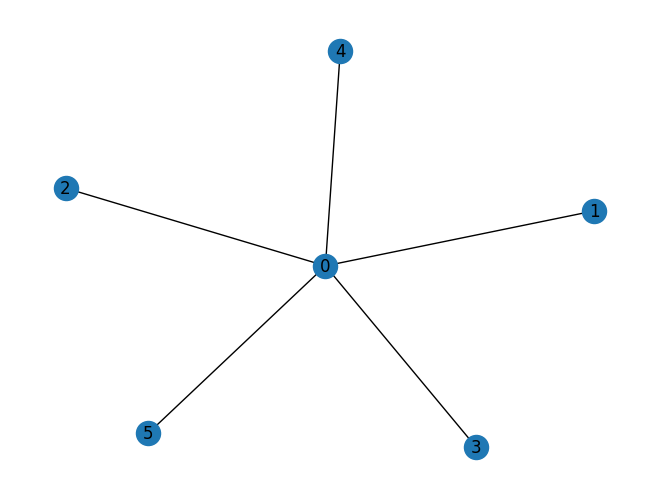

In [360]:
nx.draw(G1, with_labels = True)

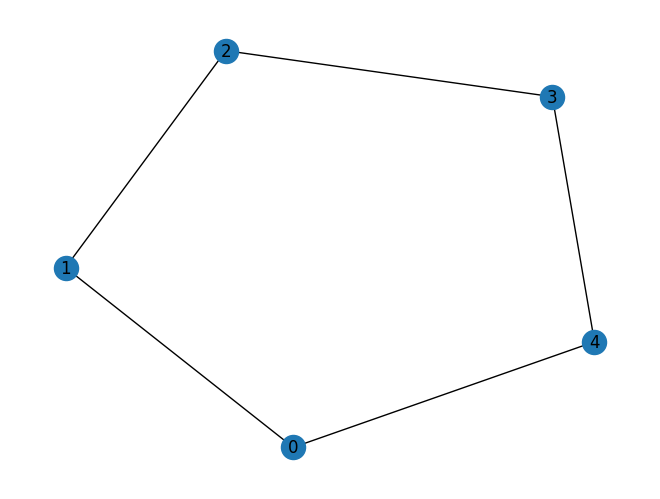

In [361]:
nx.draw(G2, with_labels = True)

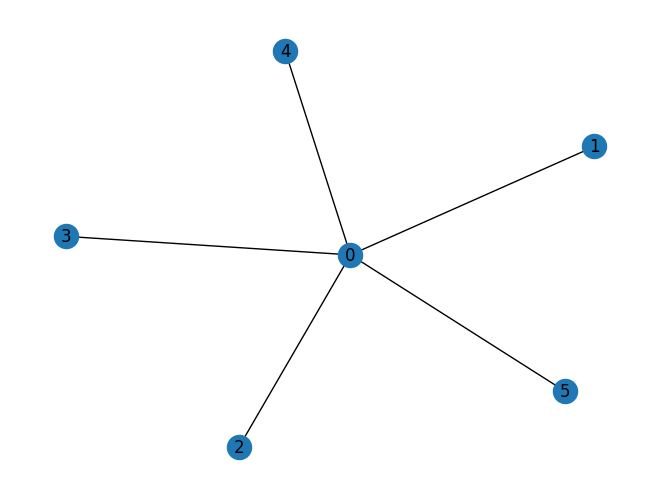

In [362]:
nx.draw(G6, with_labels = True)

### 1.2. Transform a graph
##### Compare and transform a graph G1 to G2:
+ Remove the different from G1 to G2
+ Add the different from G2 to G1

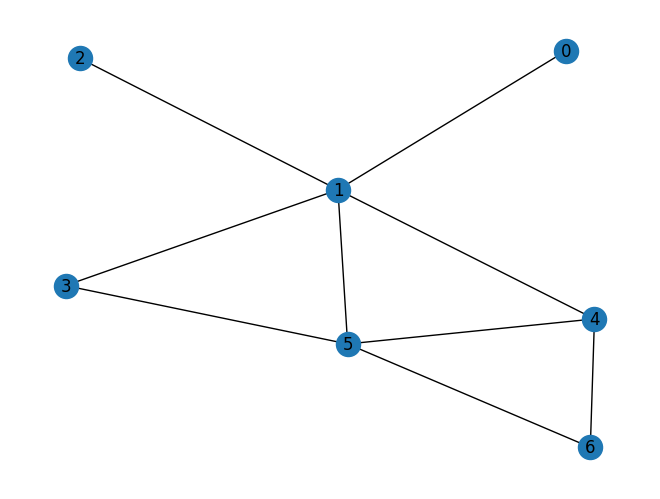

In [399]:
G1 = nx.Graph([(0, 1), (1, 2), (1, 3), (1, 4), (1, 5), (3, 5), (4, 5), (4, 6), (5, 6)])

G2 = nx.Graph([(0, 6), (1, 3), (1, 4), (1, 5), (2, 3), (3, 5), (4, 5), (4, 6), (5, 6)])

nx.draw(G1, with_labels = True)

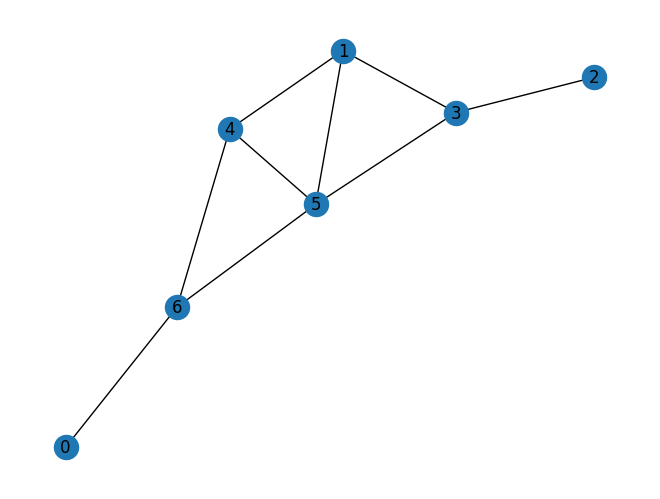

In [364]:
nx.draw(G2, with_labels = True)

In [365]:
# Check different from G1 to G2
D1 = nx.difference(G1, G2)
D1.edges

EdgeView([(0, 1), (1, 2)])

In [366]:
# Check different from G2 to G1
D2 = nx.difference(G2, G1)
D2.edges

EdgeView([(0, 6), (3, 2)])

In [367]:
# Check graph isomorphirm
nx.is_isomorphic(G1, G2)

False

##### Transform G1 to G2

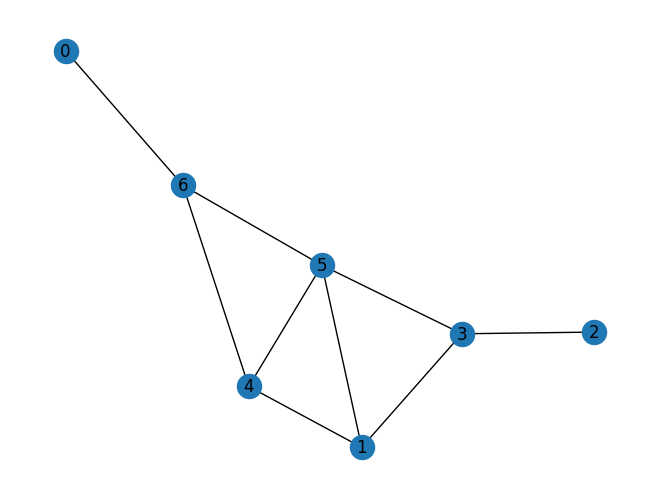

In [368]:
# Remove the different edges of G1
G1.remove_edges_from(D1.edges)
# Add the different edges of G2
G1.add_edges_from(D2.edges)
nx.draw(G1, with_labels = True)

In [369]:
# Check graph isomorphism
nx.is_isomorphic(G1, G2)

True

### 1.3. Shortest path kernel
The Shortest Path Kernel captures the structural similarities between graphs by considering the shortest paths between nodes. It is important to note that computing the kernel matrix can be computationally expensive, especially for large graphs. Therefore, there are optimization techniques available to speed up the computation, such as using approximations or graph sparsification methods.

In [370]:
# A function compute kernel methods 
# param graphs [list] store the list of graphs
# param method [string] identify the kernel method: "shortest_path", "random_walk", etc.
def compute_kernel_methods(graphs, method):
    graphs = graph_from_networkx(nx_graphs, node_labels_tag='label')

    # Compute kernel method
    gk = GraphKernel(kernel=[{"name": method}], normalize=True)
    
    # Return similarity scores among pairs of graphs in the list of graphs
    similarity_arr = gk.fit_transform(graphs)
    
    return similarity_arr

G1 = nx.complete_graph(5)
nx.set_node_attributes(G1, {0:'a', 1:'b', 2:'c', 3:'d', 4:'e'}, 'label')

G2 = nx.cycle_graph(5)
nx.set_node_attributes(G2, {0:'a', 1:'a', 2:'b', 3:'d', 4:'e'}, 'label')

nx_graphs = [G1, G2]

# Call the user-defined function to compute shortest path kernel
similarity_arr = compute_kernel_methods(nx_graphs, "shortest_path")

# Define index of 2 graphs in the array of similarity scores
G1_index = 0
G2_index = 1

print(f"Similarity between 2 graphs: {similarity_arr[G1_index][G2_index]}")

Similarity between 2 graphs: 0.3508232077228117


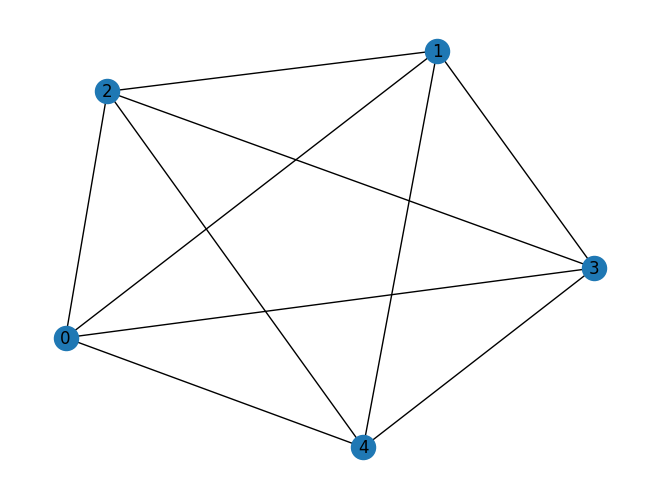

In [371]:
nx.draw(G1, with_labels = True)

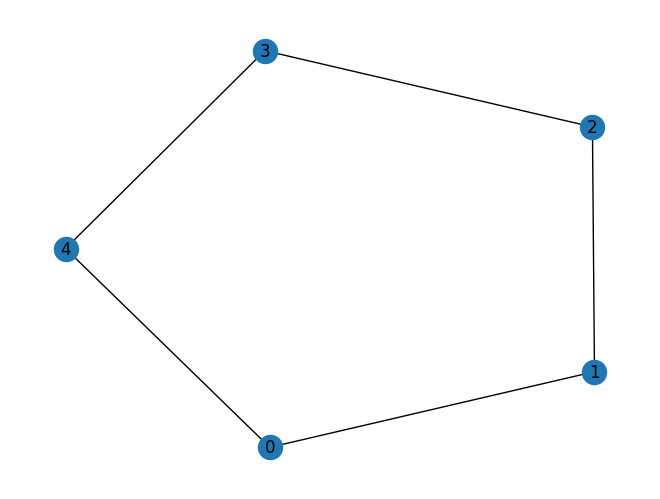

In [372]:
nx.draw(G2, with_labels = True)

### 1.4. Random walk kernel
The Random Walk Kernel captures the local neighborhood information and can handle graphs with varying sizes and structures. It is important to note that computing the kernel matrix can be computationally expensive, especially for large graphs. Various techniques are available to accelerate the computation, such as using approximations, graph sampling, or spectral methods.

In [373]:
# Initialize graphs
G1 = nx.path_graph(5)
nx.set_node_attributes(G1, {0:'a', 1:'b', 2:'c', 3:'d', 4:'e'}, 'label')

G2 = nx.Graph([(0, 6), (1, 3), (1, 4), (1, 5), (2, 3), (3, 5), (4, 5), (4, 6), (5, 6)])
nx.set_node_attributes(G2, {0:'a', 1:'c', 2:'b', 3:'h', 4:'e', 5:'d', 6: 'k'}, 'label')

nx_graphs = [G1, G2]

# Call the user-defined function to compute random walk kernel
similarity_arr = compute_kernel_methods(nx_graphs, "random_walk")

# Define index of 2 graphs in the array of similarity scores
G1_index = 0
G2_index = 1

print(f"Similarity between 2 graphs: {similarity_arr[G1_index][G2_index]}")

Similarity between 2 graphs: 0.5477125836812988


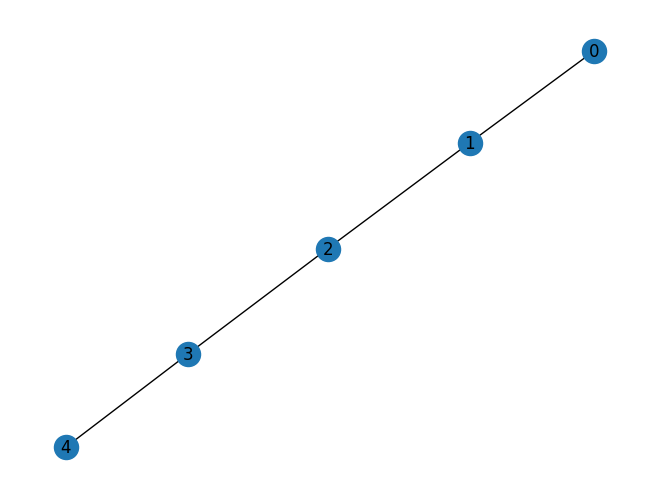

In [374]:
nx.draw(G1, with_labels = True)

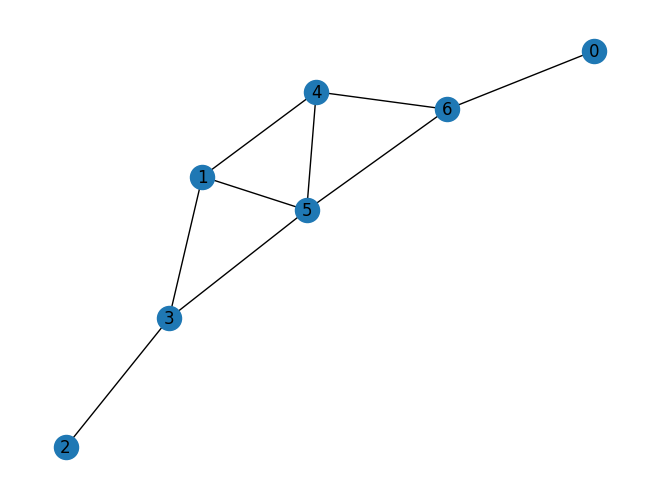

In [375]:
nx.draw(G2, with_labels = True)

### 1.5. Weisfeiler Lehman (WL)
The Weisfeiler-Lehman kernel captures the structural similarities between graphs by comparing their node labels and neighborhood structures. It is a powerful kernel that can handle graphs with varying sizes and structures. The kernel matrix can be computed efficiently using the WL subtree kernel or other optimization techniques.

In [376]:
# A base function to calculate WL
def compute_base_WL(graph, node_list, k, initial_colors_func, find_neighbors_func):  
    # Initialize colors for nodes
    colors = initial_colors_func(node_list)
    # Store the colors before computing WL algorithm
    old_colors = copy.deepcopy(colors)
    
    for i in range(len(node_list)):
        for node in node_list:
            neigh_colors = "".join([colors[i][0] for i in find_neighbors_func(graph, node_list, node)])
            colors[node].extend([neigh_colors])
            colors[node].sort()
            
        # Update color with the hash
        colors = {i: [hashlib.sha224("".join(colors[i]).encode('utf-8')).hexdigest()] for i in colors}
        
        # Count color hashes to compare new colors and old colors
        count_color_hashes = list(Counter([item for sublist in colors.values() for item in sublist]).values())
        count_old_color_hashes = list(Counter([item for sublist in old_colors.values() for item in sublist]).values())
        
        # Compare number of color hashes
        if count_color_hashes == count_old_color_hashes and i != 0:
            break
        
        old_colors = copy.deepcopy(colors)
    canonical_form = sorted(Counter([item for sublist in colors.values() for item in sublist]).items())
    
    print(f'Color hashes: \n {canonical_form} \n')
        
    return canonical_form

def kWL(G, k):
    G = nx.convert_node_labels_to_integers(G)
    node_list = list(G.nodes())

    # Considering node with k-tuples of nodes
    k_node_list = [comb for comb in itertools.combinations(node_list, k)]

    def set_initial_colors(n):
        return {i: [hashlib.sha224(str(i).encode('utf-8')).hexdigest()] for i in n}

    # Find k-hop neighbors
    def find_neighbors(G, V_k, node):
        return [n for n in V_k if len(set(n) - set(V_k[V_k.index(node)])) == 1]

    return compute_base_WL(G, k_node_list, k, set_initial_colors, find_neighbors)

def check_graph_isomorphic(G1, G2, k=2):
    # If two graphs have different numbers of nodes they cannot be isomorphic
    if len(G1.nodes()) != len(G2.nodes()):
        return False
    
    g1_hash = kWL(G1, k)
    g2_hash = kWL(G2, k)

    print(f"Checking graph isomorphic: {g1_hash==g2_hash}")
    return g1_hash == g2_hash



In [377]:
G1 = nx.Graph()
G1.add_edges_from(
    [
        ("red", "orange"),
        ("red", "yellow"),
        ("red", "green"),
        ("orange", "yellow"),
        ("yellow", "blue"),
        ("green", "blue"),
    ]
)

G2 = nx.Graph()
G2.add_edges_from(
    [
        ("yellow", "red"),
        ("yellow", "orange"),
        ("yellow", "blue"),
        ("red", "orange"),
        ("red", "green"),
        ("green", "blue"),
    ]
)

check_graph_isomorphic(G1, G2, k=3)

Color hashes: 
 [('064cdf63baa020e9729a2be3dfb26d6898ec5c22cbf931cbab7f8422', 1), ('0d9fd4b53b48313c4e37d928a1a403019196ab78327678bb13732698', 1), ('2c230336d9746fa3340a8ad457fb43e0f6a3fa7ab75bef6e6960462e', 1), ('376d7ddea05e07c0bfbc18a0b0bcee0c44d63bcc4b09e034d8bd8f8e', 1), ('378d34ba57598e48c931c48cb12b137762e0288cc5eef06a4088fac0', 1), ('42305f2729f2e48d4fdc008b82a81d567c88dfca4f905e2d5be13ad1', 1), ('555badaa64449d382c952a42860a248fb7927c6a3270ff99007e3f29', 1), ('95e09033e9ec912bfdc1d8a4e85d361de4e4c346cbe0488a45400b36', 1), ('9b1c4ce8a122f724473e54036f0b13e08d733bbf6385e1073db219ac', 1), ('a0e11c223a3ccbb8e3e266aff8117015c451f1786931dde6c5d2892d', 1)] 

Color hashes: 
 [('064cdf63baa020e9729a2be3dfb26d6898ec5c22cbf931cbab7f8422', 1), ('0d9fd4b53b48313c4e37d928a1a403019196ab78327678bb13732698', 1), ('2c230336d9746fa3340a8ad457fb43e0f6a3fa7ab75bef6e6960462e', 1), ('376d7ddea05e07c0bfbc18a0b0bcee0c44d63bcc4b09e034d8bd8f8e', 1), ('378d34ba57598e48c931c48cb12b137762e0288cc5eef06a4088

True

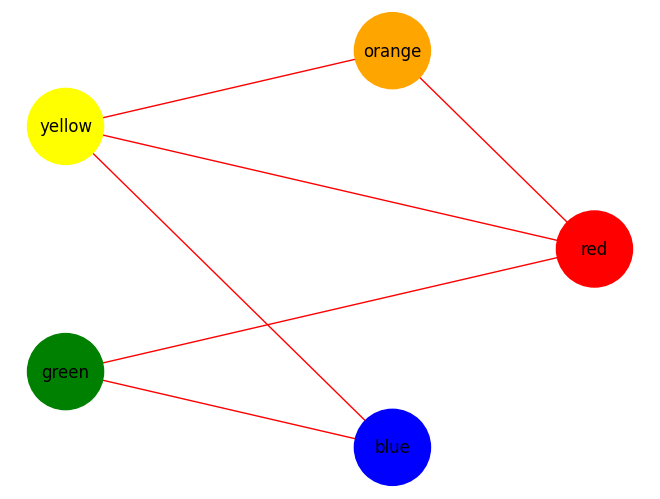

In [379]:
def draw_graph_with_node_colors(G, pos=None):
    colors = []
    for node in G:
        colors.append(node)
    options = {
        'node_color': colors,      # color of node
        'node_size': 3000,          # size of node
        'width': 1,                 # line width of edges
        'arrowstyle': '-|>',        # array style for directed graph
        'arrowsize': 18,            # size of arrow
        'edge_color':'red',         # edge color
    }

    if pos is None:
        pos = nx.circular_layout(G)

    nx.draw(G, pos, with_labels = True, arrows=False, **options)

draw_graph_with_node_colors(G1)

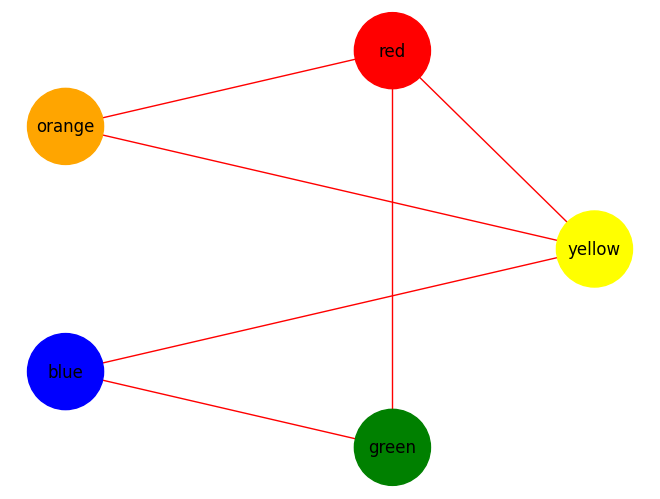

In [380]:
draw_graph_with_node_colors(G2)

## 2. Classification
### 2.1. Label propagation
Nodes with similar network connectivity or local neighborhood structures are likely to share similar labels. 
The algorithm is scalable and does not require explicit feature engineering. 
However, it heavily relies on the graph structure and the quality of the initial labeled nodes.

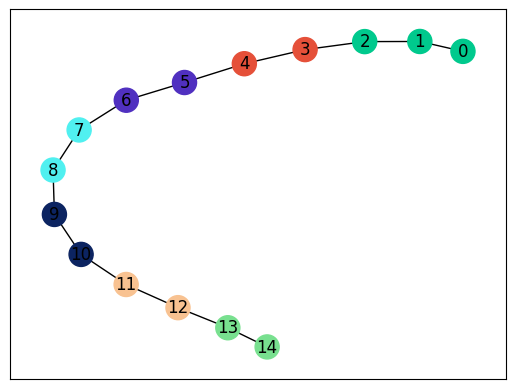

In [381]:
def draw_graph_with_label_propagation(G, colors):
    pos = nx.spring_layout(G)
    label_propagation = community.label_propagation_communities(G)
    color_map = {}

    for i in G.nodes():
            color_map[i] = "#ffffff"
    counter = 0
    for label in label_propagation:
        for n in label:
            color_map[n] = colors[counter]
        counter = counter + 1
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_nodes(G, pos, node_color=dict(color_map).values())
    nx.draw_networkx_labels(G, pos)

# Instantiate the path graph
G = nx.path_graph(15)

colors = ["#00C98D", "#e55039", "#5030C0", "#50F0F0", "#0c2461", "#f8c291", "#78e08f"]

draw_graph_with_label_propagation(G, colors)

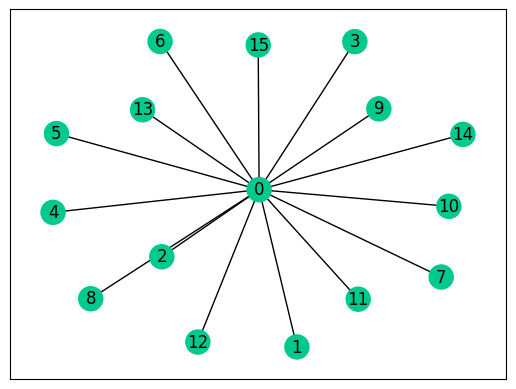

In [382]:
# Instantiate the star graph
G = nx.star_graph(15)

draw_graph_with_label_propagation(G, colors)

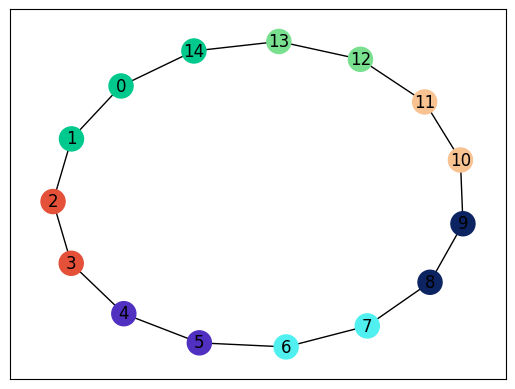

In [383]:
# Instantiate the cycle graph
G = nx.cycle_graph(15)

draw_graph_with_label_propagation(G, colors)

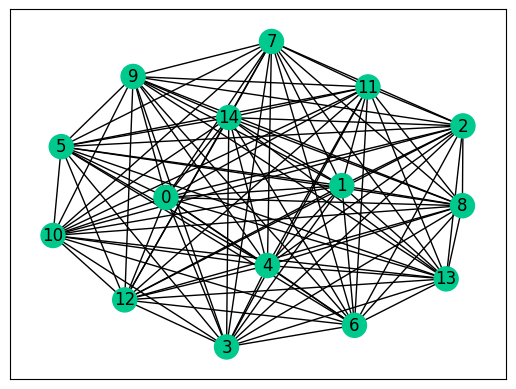

In [384]:
# Initialize the complete graph
G = nx.complete_graph(15)

draw_graph_with_label_propagation(G, colors)

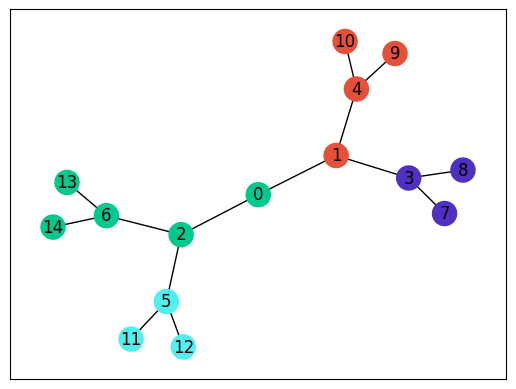

In [401]:
# Initialize tree
num_node = 15
num_child = 2

G = nx.full_rary_tree(num_child,num_node)

draw_graph_with_label_propagation(G, colors)

### 2.2. Classify label of nodes
+ Usage: SimRank based method to find node label.
+ SimRank captures the global structural similarity between nodes by considering their entire neighborhood structures. It takes into account the similarity of the nodes they are connected to, as well as the similarity of those nodes' connections, and so on. By iteratively updating the similarity values, SimRank accounts for the recursive nature of similarity.

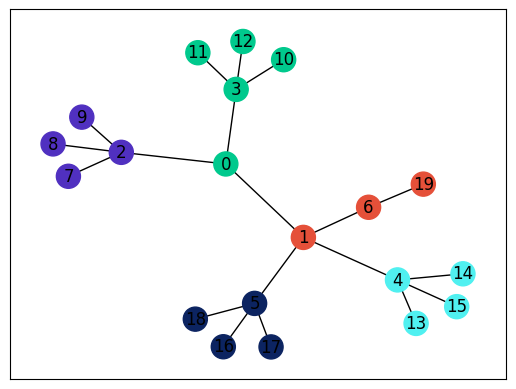

In [387]:
G = nx.full_rary_tree(3,20)

draw_graph_with_label_propagation(G, colors)

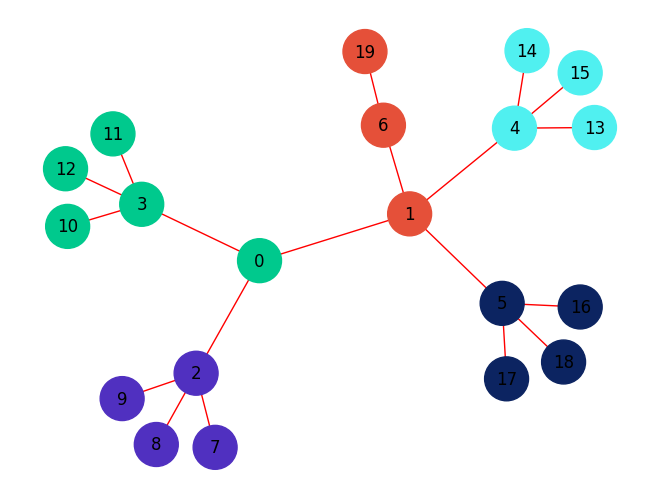

In [388]:
#fill labels in graph G
def fill_labels(G):
    colors = ["#00C98D", "#e55039", "#5030C0", "#50F0F0", "#0c2461", "#f8c291", "#78e08f"]
    label_propagation = community.label_propagation_communities(G)
    
    counter = 0
    for label in label_propagation:
        for n in label:
            G.nodes[n]['label'] = colors[counter]

        counter = counter + 1
    
    return G

def draw_graph_with_label_colors(G, pos=None):
    colors = []
    for node in G:
        colors.append(G.nodes[node]['label'])

    options = {
        'node_color': colors,      # color of node
        'node_size':1000,          # size of node
        'width': 1,                 # line width of edges
        'arrowstyle': '-|>',        # array style for directed graph
        'arrowsize': 18,            # size of arrow
        'edge_color':'red',         # edge color
    }

    if pos is None:
        pos = nx.circular_layout(G)

    nx.draw(G, pos, with_labels = True, arrows=False, **options)

fill_labels(G)
draw_graph_with_label_colors(G, pos = nx.spring_layout(G))

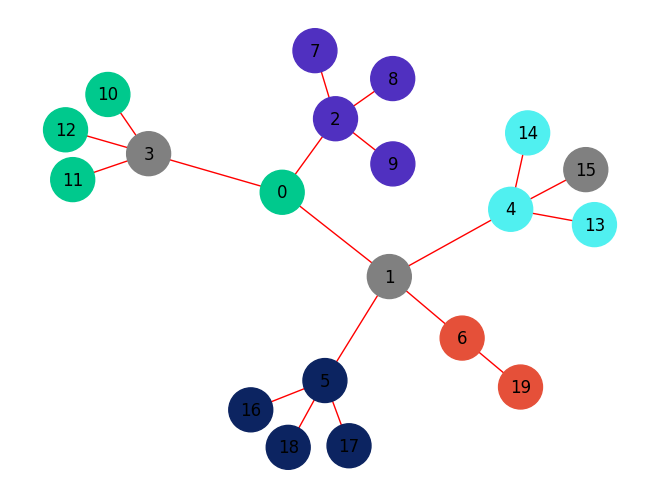

In [389]:
# Lets hide labels of node 1, 3, 15
unlabel_set = [1, 3, 15]
for n in unlabel_set:
    G.nodes[n]['label'] = 'grey'
draw_graph_with_label_colors(G, pos = nx.spring_layout(G))

In [390]:
# A function to calculate simrank similarity for an un-labelled node and assign its label based on the most similar node
def update_node_label(G, node):
    # Get Simrank similarity for a node
    simrank = nx.simrank_similarity(G, source=node)
    del simrank[node]
    print(f"+ Simrank score for node {node}: {simrank}")

    #finding the nodeID that have highest Simrank.
    most_similar_node = max(simrank, key=lambda k: simrank[k])
    
    print(f"+ Most similar node of node {node}: {most_similar_node} \n")

    G.nodes[node]['label'] = G.nodes[most_similar_node]['label']

In [391]:
# Update labels for un-labelled nodes
for n in unlabel_set:
    update_node_label(G, n)

+ Simrank score for node 1: {0: 0.0, 2: 0.3330228223831273, 3: 0.3330228223831273, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.5081882576164559, 14: 0.5081882576164559, 15: 0.5081882576164559, 16: 0.5081882576164559, 17: 0.5081882576164559, 18: 0.5081882576164559, 19: 0.5411906657064056}
+ Most similar node of node 1: 19 

+ Simrank score for node 3: {0: 0.0, 1: 0.3330228223831273, 2: 0.4313760949639694, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.23533710770485322, 14: 0.23533710770485322, 15: 0.23533710770485322, 16: 0.23533710770485322, 17: 0.23533710770485322, 18: 0.23533710770485322, 19: 0.2791748781952372}
+ Most similar node of node 3: 2 

+ Simrank score for node 15: {0: 0.0, 1: 0.5081882576164558, 2: 0.23533710770485322, 3: 0.23533710770485322, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.9, 14: 0.9, 16: 0.37643581590776864, 17: 0.37643581590776864, 18: 0.3764358159077

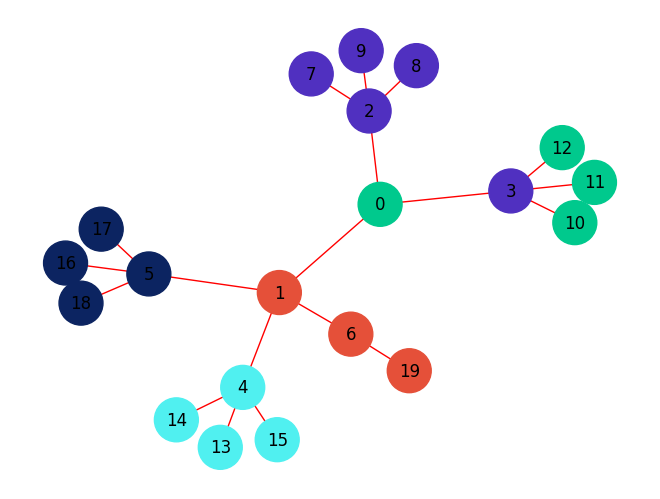

In [394]:
draw_graph_with_label_colors(G, pos = nx.spring_layout(G))

### 2.3. Rolx algorithm
The algorithm captures the structural regularities and functional roles of nodes in the network. It assigns role labels to nodes based on their local and global connectivity patterns. The algorithm iteratively refines the role labels by considering the roles of neighboring nodes, thereby revealing the latent structure of the network.

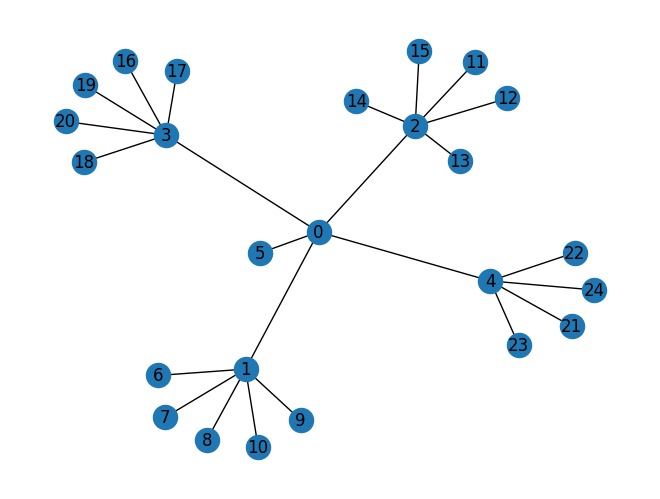

In [395]:
# Initialize a graph
G = nx.full_rary_tree(5,25)

nx.draw(G, with_labels = True)

In [396]:
# A function compute role extraction to assign roles for nodes
def assign_roles(G, num_roles=5):
    # extract features from 1 recursive generations:
    feature_extractor = RecursiveFeatureExtractor(G)
    features = feature_extractor.extract_features()

    print(f'\nFeatures extracted from {feature_extractor.generation_count} recursive generations:')
    print(features)
    
    # assign node roles
    role_extractor = RoleExtractor(n_roles=None)
    role_extractor.extract_role_factors(features)
    node_roles = role_extractor.roles

    print('\nNode role membership by percentage:')
    print(role_extractor.role_percentage.round(2))
    
    return node_roles

In [397]:
node_roles = assign_roles(G)


Features extracted from 1 recursive generations:
    degree  external_edges
0        5              19
1        6               4
2        6               4
3        6               4
4        5               4
5        1               4
6        1               5
7        1               5
8        1               5
9        1               5
10       1               5
11       1               5
12       1               5
13       1               5
14       1               5
15       1               5
16       1               5
17       1               5
18       1               5
19       1               5
20       1               5
21       1               4
22       1               4
23       1               4
24       1               4

Node role membership by percentage:
    role_0  role_1
0     0.50    0.50
1     0.01    0.99
2     0.01    0.99
3     0.01    0.99
4     0.01    0.99
5     0.64    0.36
6     0.64    0.36
7     0.64    0.36
8     0.64    0.36
9     0.64    0.36
10

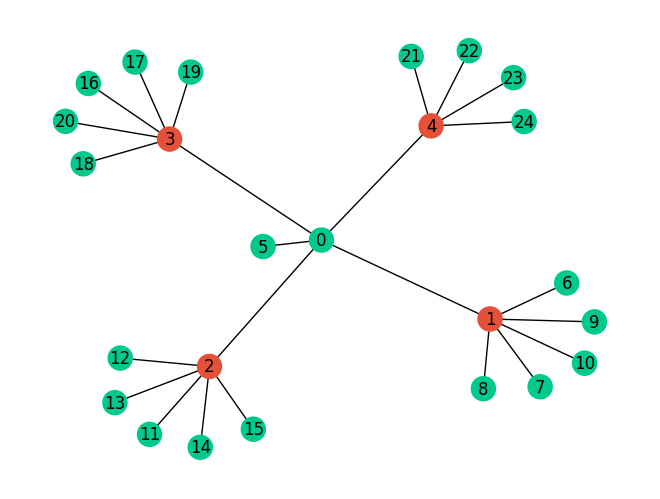

In [398]:
def draw_graph_from_roles(G, node_roles):
    # build color palette for plotting
    unique_roles = sorted(set(node_roles.values()))
    color_map = ["#00C98D", "#e55039", "#5030C0", "#50F0F0", "#0c2461", "#f8c291", "#78e08f"]
    # map roles to colors
    role_colors = {role: color_map[i] for i, role in enumerate(unique_roles)}
    # build list of colors for all nodes in G
    node_colors = [role_colors[node_roles[node]] for node in G.nodes]
    # plot graph
    plt.figure()

    with warnings.catch_warnings():
        # catch matplotlib deprecation warning
        warnings.simplefilter('ignore')
        nx.draw(
            G,
            pos=nx.spring_layout(G, seed=42),
            with_labels=True,
            node_color=node_colors,
        )
        
draw_graph_from_roles(G, node_roles)